In [1]:
import geodatasets
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import numpy as np

### Load USA map and move and scale Alaska, Hawaii and Puerto Rico

In [2]:
# Load US states GeoJSON
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
states = gpd.read_file(url)

# Separate Alaska and mainland
alaska = states[states['name'] == 'Alaska'].copy()
hawaii = states[states['name'] == 'Hawaii'].copy()
puerto_rico = states[states['name'] == 'Puerto Rico'].copy()
mainland = states[~states['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])].copy()

# Scale and move Alaska
alaska.geometry = alaska.geometry.scale(xfact=0.25, yfact=0.25, origin='center')
alaska.geometry = alaska.geometry.translate(xoff=40, yoff=-33)

# Scale and move Hawaii
hawaii.geometry = hawaii.geometry.scale(xfact=1.25, yfact=1.25, origin='center')
hawaii.geometry = hawaii.geometry.translate(xoff=50, yoff=7)

# Scale and move Puerto Rico
puerto_rico.geometry = puerto_rico.geometry.scale(xfact=1.5, yfact=1.5, origin='center')
puerto_rico.geometry = puerto_rico.geometry.translate(xoff=-10, yoff=10)

# Combine using pd.concat
states_adjusted = pd.concat([mainland, alaska, hawaii, puerto_rico], ignore_index=True)
states_adjusted_1 = states_adjusted.copy()

## Load csv files

In [3]:
df_executions = pd.read_csv("datasets/executions.csv")
justices_df = pd.read_csv('datasets/number_of_justices.csv')
districts_df = pd.read_csv('datasets/number_of_federal_judicial_districts.csv')
selection_df = pd.read_csv('datasets/mode_of_selection.csv')
espy_df = pd.read_csv('datasets/ESPYFile.csv')

#### Stany USA według metody wyboru sędziów

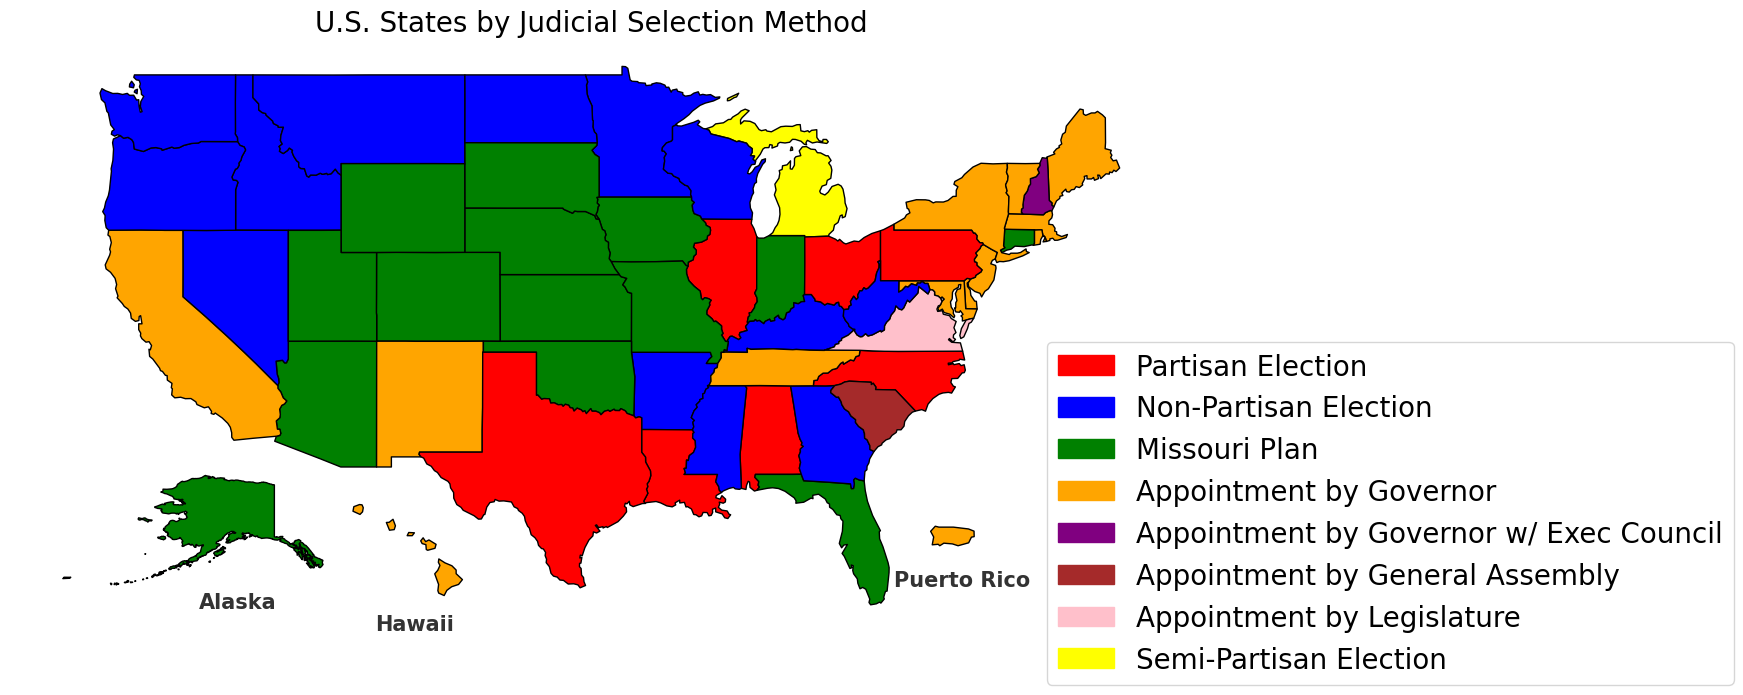

In [4]:
# Create state -> election type mapping
state_to_election_type = dict(zip(selection_df['State'], selection_df['Election Type']))

# Color map with keys matching CSV election types
selection_color_map = {
    'Partisan Election': 'red',
    'Non-Partisan Election': 'blue',
    'Missouri Plan': 'green',
    'Appointment by Governor': 'orange',
    'Appointment by Governor w/ Exec Council': 'purple',
    'Appointment by General Assembly': 'brown',
    'Appointment by Legislature': 'pink',
    'Semi-Partisan Election': 'yellow'
}

# Color function using the dictionary
def get_selection_color(state):
    election_type = state_to_election_type.get(state, None)
    if election_type is not None:
        return selection_color_map.get(election_type, 'lightgray')
    else:
        return 'lightgray'

# Apply colors
states_adjusted['color'] = states_adjusted['name'].apply(get_selection_color)

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
states_adjusted.plot(ax=ax, edgecolor='black', color=states_adjusted['color'])
ax.set_title('U.S. States by Judicial Selection Method', fontsize=20)
ax.set_axis_off()

# Calculate bounds of all states combined
bounds = states_adjusted.total_bounds  # returns [minx, miny, maxx, maxy]
alaska_text_x = ((bounds[0] + bounds[2]) / 2) - 20
alaska_text_y = ((bounds[1] + bounds[3]) / 2) - 12
hawaii_text_x = ((bounds[0] + bounds[2]) / 2) - 10
hawaii_text_y = ((bounds[1] + bounds[3]) / 2) - 13
pr_text_x = ((bounds[0] + bounds[2]) / 2) + 21
pr_text_y = ((bounds[1] + bounds[3]) / 2) - 11

ax.text(alaska_text_x, alaska_text_y, 'Alaska', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(hawaii_text_x, hawaii_text_y, 'Hawaii', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(pr_text_x, pr_text_y, 'Puerto Rico', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

# Create legend patches
legend_patches = [
    mpatches.Patch(color='red', label='Partisan Election'),
    mpatches.Patch(color='blue', label='Non-Partisan Election'),
    mpatches.Patch(color='green', label='Missouri Plan'),
    mpatches.Patch(color='orange', label='Appointment by Governor'),
    mpatches.Patch(color='purple', label='Appointment by Governor w/ Exec Council'),
    mpatches.Patch(color='brown', label='Appointment by General Assembly'),
    mpatches.Patch(color='pink', label='Appointment by Legislature'),
    mpatches.Patch(color='yellow', label='Semi-Partisan Election')
]

ax.legend(
    handles=legend_patches,
    loc='center left',
    bbox_to_anchor=(0.88, 0.2),
    fontsize=20,
    frameon=True
)

plt.show()

Bibliografia:
* https://afj.org/statecourts/
* https://en.wikipedia.org/wiki/State_supreme_court

##### Stanowe Sądy Najwyższe USA: Liczba sędziów

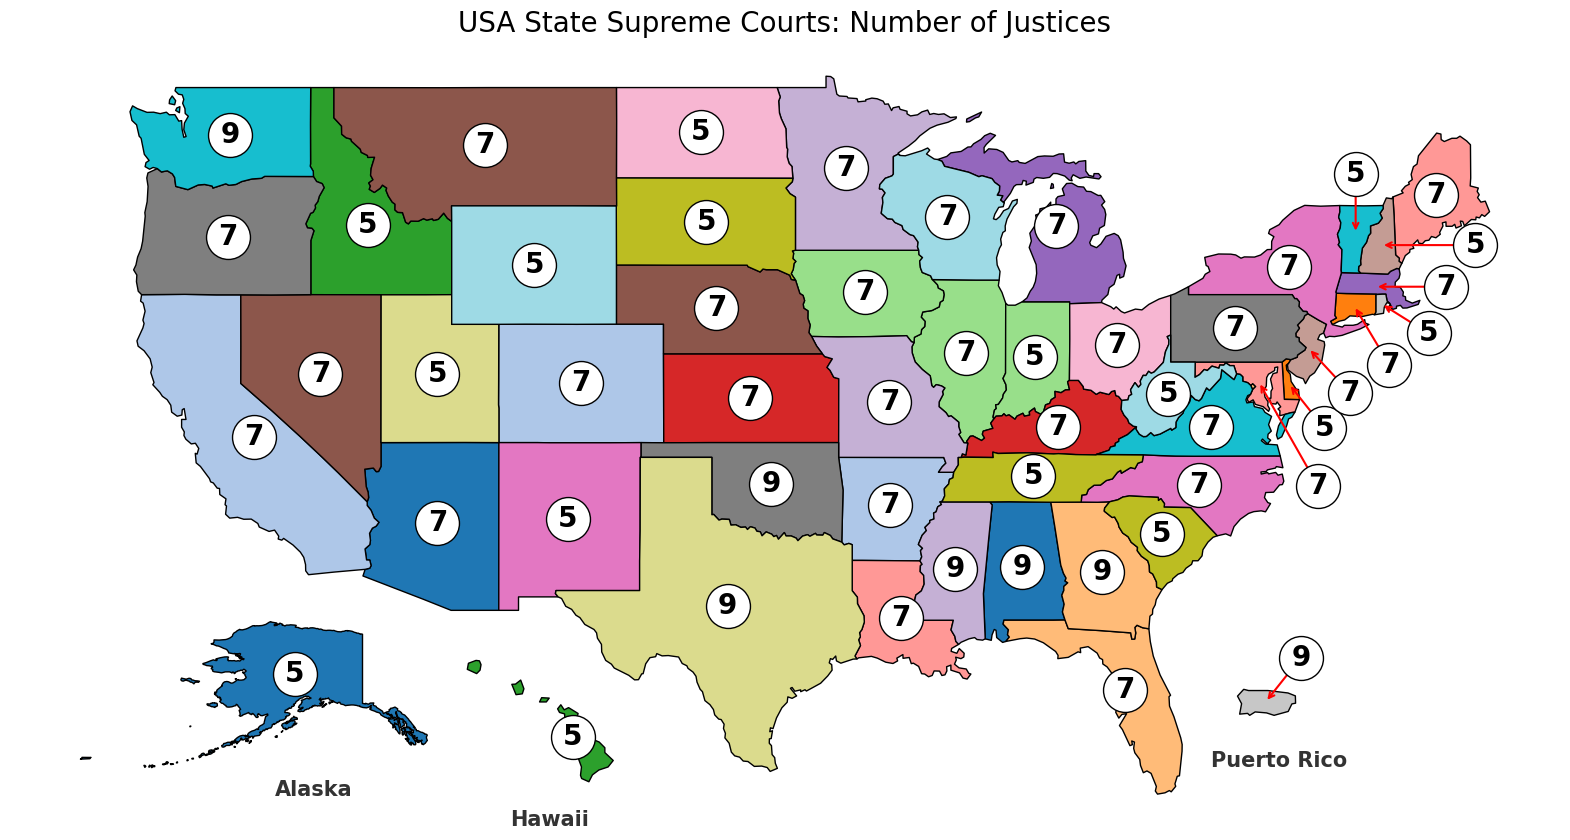

In [5]:
# Create dictionary from DataFrame: {state_name: number_of_justices}
justices_by_state = pd.Series(justices_df['Number of Justices'].values, index=justices_df['State']).to_dict()

states_proj = states_adjusted_1.to_crs(epsg=2163)
states_proj['centroid'] = states_proj.geometry.centroid
states_adjusted_1['centroid'] = states_proj['centroid'].to_crs(states_adjusted_1.crs)

# States with shifted labels (unchanged)
label_shifts = {
    'Rhode Island':      (2, -1),
    'Connecticut':       (1.5, -2),
    'Vermont':           (0, 2),
    'New Hampshire':     (4, 0),
    'Massachusetts':     (3, 0),
    'New Jersey':        (1.75, -1.5),
    'Delaware':          (1.5, -1.5),
    'Maryland':          (2.5, -3.5),
    'Puerto Rico':       (1.5, 1.5)
}

# Plot
fig, ax = plt.subplots(figsize=(20, 15))
states_adjusted_1.plot(ax=ax, edgecolor='black', cmap='tab20', column='name', legend=False)

def draw_label(ax, x, y, label, size=1000, fontsize=20, shift=None):
    """Helper to draw circle and label, optionally with arrow"""
    if shift:
        dx, dy = shift
        sx, sy = x + dx, y + dy

        # Draw arrow first (under)
        ax.annotate('', xy=(x, y), xytext=(sx, sy),
                    arrowprops=dict(color='red', arrowstyle='->', lw=1.5),
                    zorder=4)

        # Draw shifted label
        ax.scatter(sx, sy, s=size, color='white', edgecolor='black', zorder=5)
        ax.text(sx, sy, label, ha='center', va='center', fontsize=fontsize, fontweight='bold', zorder=6)
    else:
        ax.scatter(x, y, s=size, color='white', edgecolor='black', zorder=5)
        ax.text(x, y, label, ha='center', va='center', fontsize=fontsize, fontweight='bold', zorder=6)

# Draw all state labels
for _, row in states_adjusted_1.iterrows():
    state = row['name']
    if state == 'District of Columbia':
        continue

    x, y = row['centroid'].x, row['centroid'].y
    num_justices = justices_by_state.get(state)

    if num_justices is None:
        continue  # skip if state not in the CSV

    shift = label_shifts.get(state)
    draw_label(ax, x, y, str(num_justices), shift=shift)

# Calculate bounds of all states combined
bounds = states_adjusted_1.total_bounds  # returns [minx, miny, maxx, maxy]
alaska_text_x = ((bounds[0] + bounds[2]) / 2) - 20
alaska_text_y = ((bounds[1] + bounds[3]) / 2) - 12
hawaii_text_x = ((bounds[0] + bounds[2]) / 2) - 10
hawaii_text_y = ((bounds[1] + bounds[3]) / 2) - 13
pr_text_x = ((bounds[0] + bounds[2]) / 2) + 21
pr_text_y = ((bounds[1] + bounds[3]) / 2) - 11

ax.text(alaska_text_x, alaska_text_y, 'Alaska', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(hawaii_text_x, hawaii_text_y, 'Hawaii', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(pr_text_x, pr_text_y, 'Puerto Rico', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

# Final touches
ax.set_title('USA State Supreme Courts: Number of Justices', fontsize=20)
ax.set_axis_off()
plt.show()

Bibliografia:
* https://afj.org/statecourts/
* https://en.wikipedia.org/wiki/State_supreme_court

####  Aresztowania federalne według stanu

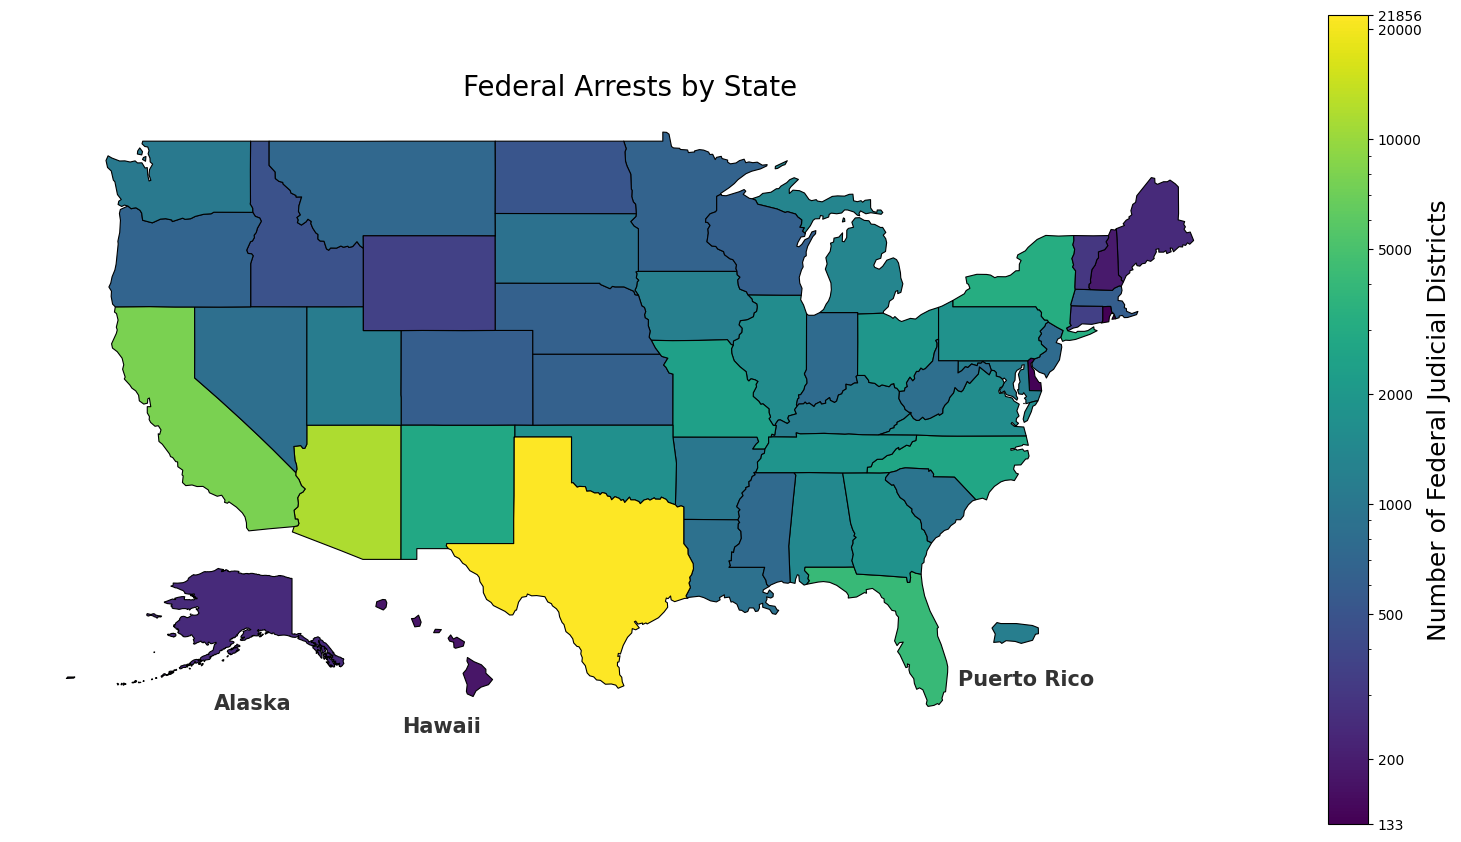

In [6]:
# Assuming your states_adjusted_1 GeoDataFrame has a 'name' column with state names matching the CSV's 'state'
# Create a dictionary from the CSV for mapping
districts_by_state = dict(zip(districts_df['Federal Judicial District'], districts_df['Number']))

# Map the 'districts' column to the GeoDataFrame
states_adjusted_1['districts'] = states_adjusted_1['name'].map(districts_by_state)

# Set up the log scale
vmin = states_adjusted_1['districts'].min()
vmax = states_adjusted_1['districts'].max()
log_norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 15))
plot = states_adjusted_1.plot(
    column='districts',
    cmap='viridis',
    linewidth=0.8,
    edgecolor='black',
    norm=log_norm,
    ax=ax
)

# Add colorbar with real number ticks, smaller size
sm = plt.cm.ScalarMappable(cmap='viridis', norm=log_norm)
sm._A = []  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)  # Shrink the colorbar to 70% size
cbar.set_label("Number of Federal Judicial Districts", fontsize=18)

# Set log-spaced ticks with actual values
log_ticks = [int(vmin), 200, 500, 1000, 2000, 5000, 10000, 20000, int(vmax)]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([str(tick) for tick in log_ticks])

# Calculate bounds of all states combined
bounds = states_adjusted_1.total_bounds  # returns [minx, miny, maxx, maxy]
alaska_text_x = ((bounds[0] + bounds[2]) / 2) - 20
alaska_text_y = ((bounds[1] + bounds[3]) / 2) - 12
hawaii_text_x = ((bounds[0] + bounds[2]) / 2) - 10
hawaii_text_y = ((bounds[1] + bounds[3]) / 2) - 13
pr_text_x = ((bounds[0] + bounds[2]) / 2) + 21
pr_text_y = ((bounds[1] + bounds[3]) / 2) - 11

ax.text(alaska_text_x, alaska_text_y, 'Alaska', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(hawaii_text_x, hawaii_text_y, 'Hawaii', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(pr_text_x, pr_text_y, 'Puerto Rico', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

# Final touches
ax.set_title('Federal Arrests by State', fontsize=20)
ax.set_axis_off()
plt.show()

Bibliografia:
* https://bjs.ojp.gov/library/publications/federal-justice-statistics-2023

#### Liczba egzekucji według stanu

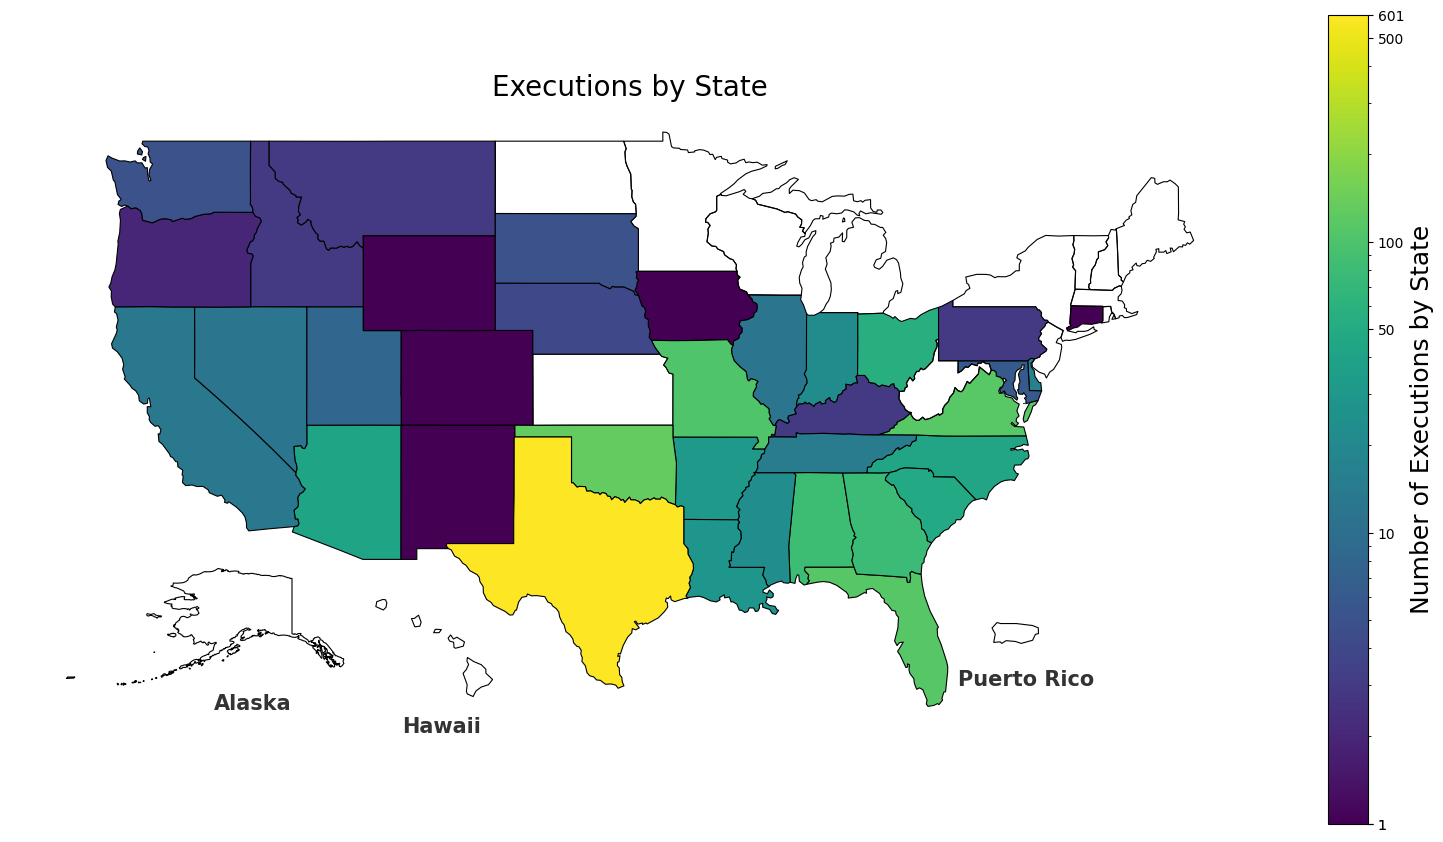

In [7]:
state_counts = df_executions['State'].value_counts()

# 2. Assuming you have a GeoDataFrame named states_adjusted_1 with a 'name' column for states

# Map the execution counts to the GeoDataFrame
states_adjusted_1['districts'] = states_adjusted_1['name'].map(state_counts).fillna(0).astype(int)

# 3. Set up log scale normalization for the color mapping
vmin = states_adjusted_1['districts'].replace(0, pd.NA).min()  # ignore zeros for vmin
vmax = states_adjusted_1['districts'].max()
log_norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# 4. Plot the states with execution counts instead of district counts
fig, ax = plt.subplots(figsize=(20, 15))
plot = states_adjusted_1.plot(
    column='districts',
    cmap='viridis',
    linewidth=0.8,
    edgecolor='black',
    norm=log_norm,
    ax=ax
)

# 5. Add colorbar with appropriate ticks and labels
sm = plt.cm.ScalarMappable(cmap='viridis', norm=log_norm)
sm._A = []  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("Number of Executions by State", fontsize=18)

# Log spaced ticks, adjusted for your data range
log_ticks = [vmin, 1, 10, 50, 100, 500, vmax]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([str(tick) for tick in log_ticks])

# Calculate bounds of all states combined
bounds = states_adjusted_1.total_bounds  # returns [minx, miny, maxx, maxy]
alaska_text_x = ((bounds[0] + bounds[2]) / 2) - 20
alaska_text_y = ((bounds[1] + bounds[3]) / 2) - 12
hawaii_text_x = ((bounds[0] + bounds[2]) / 2) - 10
hawaii_text_y = ((bounds[1] + bounds[3]) / 2) - 13
pr_text_x = ((bounds[0] + bounds[2]) / 2) + 21
pr_text_y = ((bounds[1] + bounds[3]) / 2) - 11

ax.text(alaska_text_x, alaska_text_y, 'Alaska', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(hawaii_text_x, hawaii_text_y, 'Hawaii', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

ax.text(pr_text_x, pr_text_y, 'Puerto Rico', fontsize=15, fontweight='bold', ha='center', va='center', alpha=0.8, color='black')

# Final touches
ax.set_title('Executions by State', fontsize=20)
ax.set_axis_off()
plt.show()

Bibliografia:
* https://deathpenaltyinfo.org/facts-and-research/data/executions
* https://en.wikipedia.org/wiki/Capital_punishment_in_the_United_States#Clemency_and_commutations

#### Liczba egzekucji rocznie

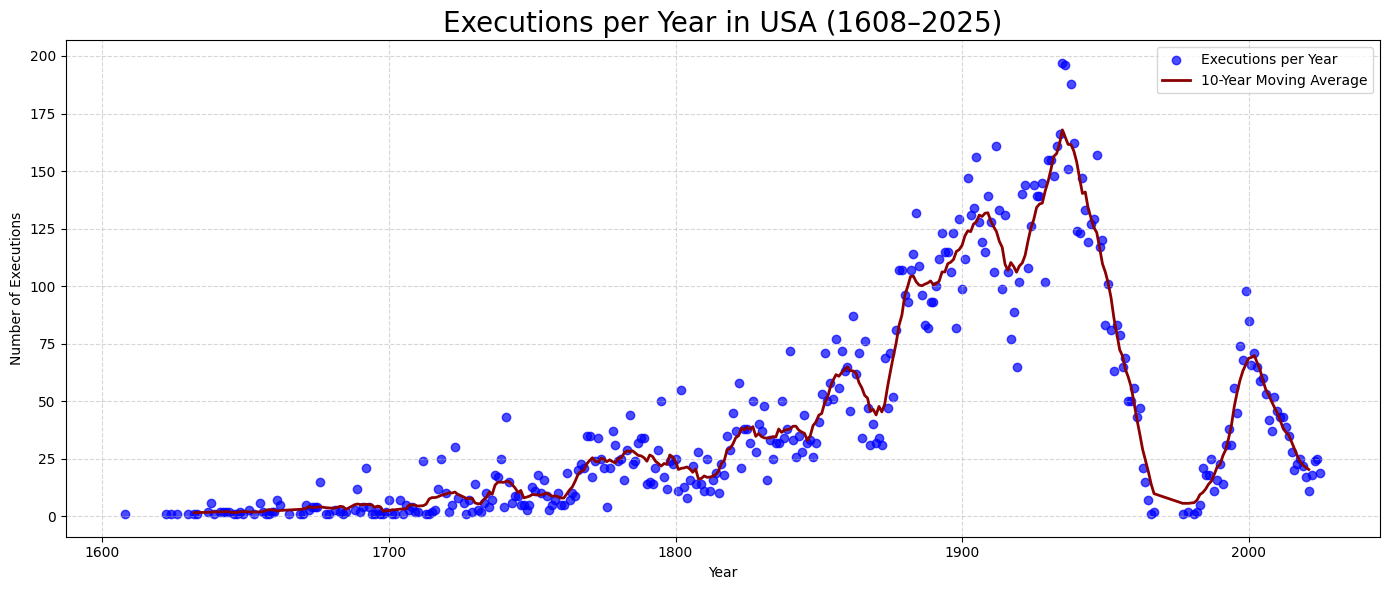

In [8]:
# Parse 'Execution Date' and extract year
df_executions['Execution Date'] = pd.to_datetime(df_executions['Execution Date'], format='%m/%d/%Y', errors='coerce')
df_executions['YEAR'] = df_executions['Execution Date'].dt.year

# Keep only years before 1977 in ESPY data to avoid overlap
espy_df_filtered = espy_df[espy_df['YEAR'] < 1977]

# Combine datasets
combined_df = pd.concat([espy_df_filtered, df_executions], ignore_index=True)

# Group by year and count executions
executions_per_year = combined_df.groupby('YEAR').size().sort_index()

# Compute moving average (e.g., 10-year window)
moving_avg = executions_per_year.rolling(window=10, center=True).mean()

# Plot
plt.figure(figsize=(14, 6))
plt.scatter(executions_per_year.index, executions_per_year.values, color='blue', alpha=0.7, label='Executions per Year')
plt.plot(moving_avg.index, moving_avg.values, color='darkred', linewidth=2, label='10-Year Moving Average')
plt.title('Executions per Year in USA (1608–2025)', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Number of Executions')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Bibliografia:
* https://deathpenaltyinfo.org/facts-and-research/data/executions
* https://en.wikipedia.org/wiki/Capital_punishment_in_the_United_States#Clemency_and_commutations

#### Egzekucje według rasy

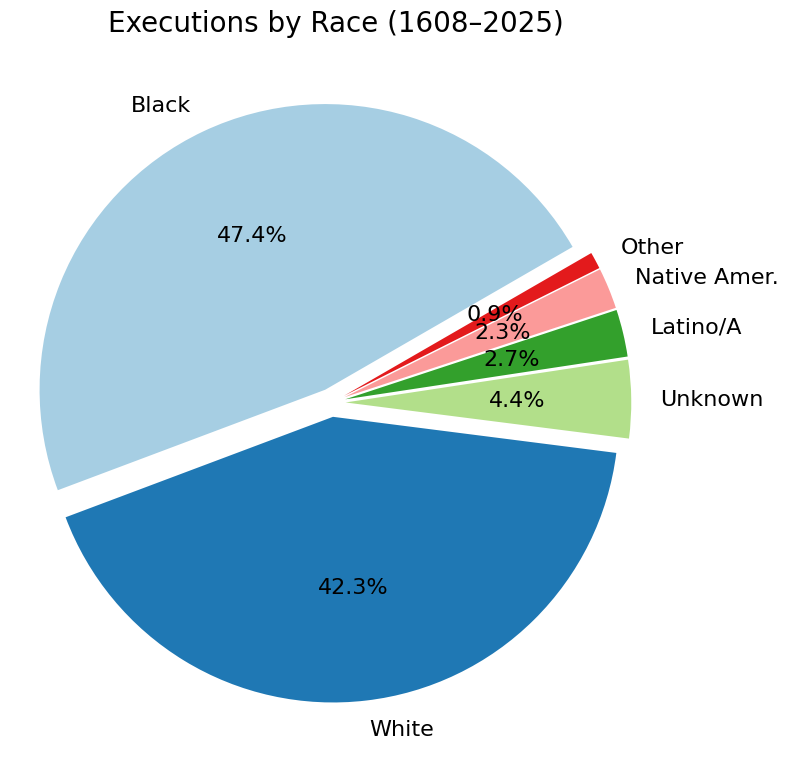

In [9]:
# Convert 'Execution Date' to datetime and extract year
df_executions['Execution Date'] = pd.to_datetime(df_executions['Execution Date'], format='%m/%d/%Y', errors='coerce')
df_executions['YEAR'] = df_executions['Execution Date'].dt.year

# Filter espyfile_df to years before 1977
espy_df_filtered = espy_df[espy_df['YEAR'] < 1977]

# Rename race columns for consistency
df_executions = df_executions.rename(columns={'Race': 'RACE'})
espy_df_filtered = espy_df_filtered.rename(columns={'RACE': 'RACE'})

# Combine datasets
combined_df = pd.concat([espy_df_filtered, df_executions], ignore_index=True)

# Standardize and combine race categories
combined_df['RACE'] = combined_df['RACE'].str.strip().str.title()  # Clean formatting
combined_df['RACE'] = combined_df['RACE'].replace({
    'Latino/A': 'Latino/A',
    'Hispanic': 'Latino/A',
    'Other Race': 'Other',
    'Asian': 'Other',
    'Asian - Pacific Is': 'Other',
    'American Indian Or Alaska Native': 'Native Amer.'
})

# Count executions by race
race_counts = combined_df['RACE'].dropna().value_counts()

explode = [0.05] * len(race_counts)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    race_counts.values,
    labels=race_counts.index,
    autopct='%1.1f%%',
    startangle=30,
    explode=explode,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 16},
)
plt.title('Executions by Race (1608–2025)', fontsize=20)
plt.axis('equal')  # Equal aspect ratio
plt.tight_layout()
plt.show()

Bibliografia:
* https://deathpenaltyinfo.org/facts-and-research/data/executions
* https://en.wikipedia.org/wiki/Capital_punishment_in_the_United_States#Clemency_and_commutations

#### Egzekucje według płci

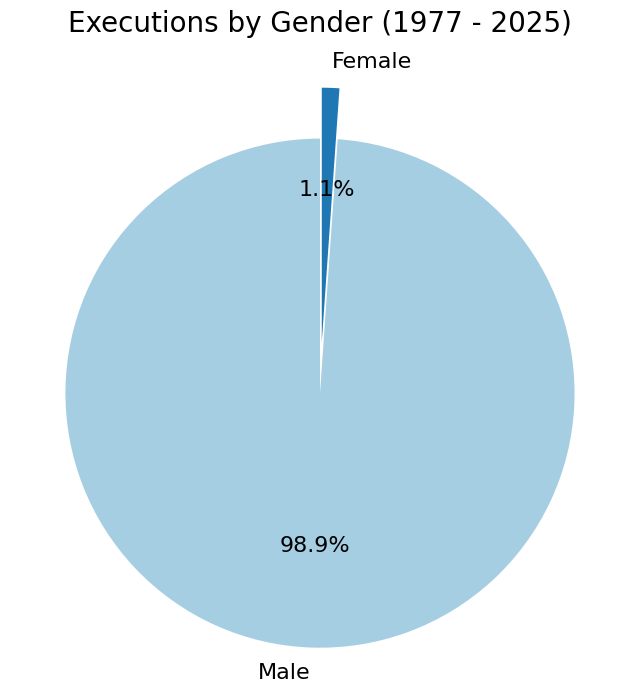

In [10]:
# Count the occurrences of each category in the 'Sex' column
sex_counts = df_executions['Sex'].value_counts()

explode = [0.1] * len(sex_counts)

# Plot pie chart
plt.figure(figsize=(8,8))
sex_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    explode=explode,
    startangle=90,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 16},
)
plt.title('Executions by Gender (1977 - 2025)', fontsize=20, pad=20)  # Add padding below title
plt.ylabel('')  # Hide y-label for better pie chart display
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular

plt.show()

Bibliografia:
* https://deathpenaltyinfo.org/facts-and-research/data/executions
* https://en.wikipedia.org/wiki/Capital_punishment_in_the_United_States#Clemency_and_commutations

#### Metoda egzekucji

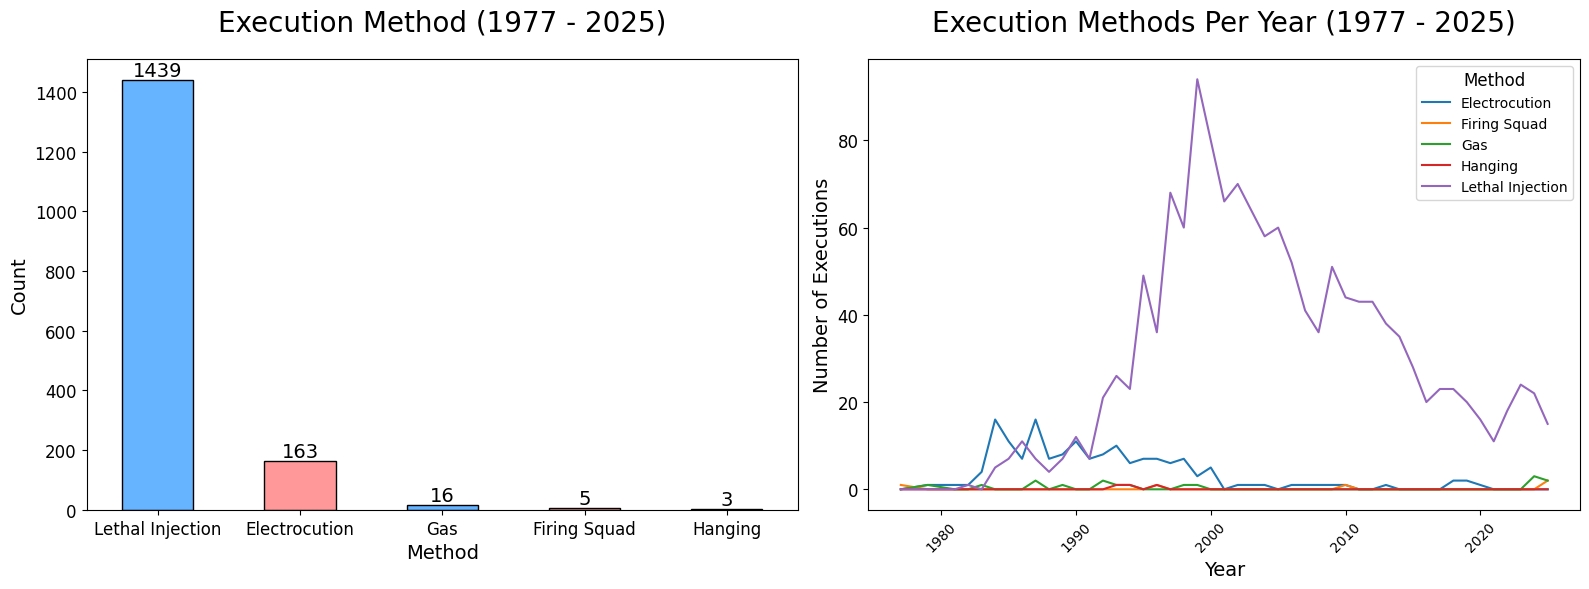

In [11]:
# Count the occurrences of each category in the 'Method' column
method_counts = df_executions['Method'].value_counts()

# Group by year and method for the line plot
method_by_year = df_executions.groupby(['YEAR', 'Method']).size().unstack(fill_value=0)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot - Execution Method Total Counts
method_counts.plot(
    kind='bar',
    color=['#66b3ff', '#ff9999'],  # Update if more than two methods
    edgecolor='black',
    ax=axes[0]
)

axes[0].set_title('Execution Method (1977 - 2025)', fontsize=20, pad=20)
axes[0].set_xlabel('Method', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', labelrotation=0, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Add counts on top of each bar
for i, count in enumerate(method_counts):
    axes[0].text(i, count + max(method_counts)*0.01, str(count), ha='center', fontsize=14)

# Line plot - Execution Methods Over Time
method_by_year.plot(ax=axes[1])

axes[1].set_title('Execution Methods Per Year (1977 - 2025)', fontsize=20, pad=20)
axes[1].set_xlabel('Year', fontsize=14)
axes[1].set_ylabel('Number of Executions', fontsize=14)
axes[1].tick_params(axis='x', labelrotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(title='Method', fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()

Bibliografia:
* https://deathpenaltyinfo.org/facts-and-research/data/executions
* https://en.wikipedia.org/wiki/Capital_punishment_in_the_United_States#Clemency_and_commutations